In [1]:
import pandas as pd
import numpy as np

from ucimlrepo import fetch_ucirepo

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

## Classification :: Bank Marketing, predict if the client will subscribe a term deposit

In [2]:
bank_marketing = fetch_ucirepo(name='Bank Marketing')

In [3]:
print(bank_marketing.metadata.get('additional_info').get('variable_info'))

Input variables:
   # bank client data:
   1 - age (numeric)
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   4 - education (categorical: "unknown","secondary","primary","tertiary")
   5 - default: has credit in default? (binary: "yes","no")
   6 - balance: average yearly balance, in euros (numeric) 
   7 - housing: has housing loan? (binary: "yes","no")
   8 - loan: has personal loan? (binary: "yes","no")
   # related with the last contact of the current campaign:
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
  10 - day: last contact day of the month (numeric)
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "no

In [4]:
df_bank_marketing = bank_marketing.data.get('original')

In [5]:
df_bank_marketing.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
38191,34,blue-collar,married,secondary,no,2139,yes,no,cellular,15,may,1452,1,-1,0,NaN,no
29459,58,retired,married,primary,no,3401,yes,no,cellular,3,feb,84,3,265,2,failure,no
23116,34,technician,single,secondary,no,1974,no,no,cellular,26,aug,603,3,-1,0,NaN,no
19260,34,management,married,tertiary,no,0,no,no,cellular,6,aug,139,2,-1,0,NaN,no
37789,23,blue-collar,single,secondary,no,1105,yes,no,cellular,14,may,377,1,-1,0,NaN,no


# 1. Check the distribution of the Dependent Variable
---

<big>

Watch out for **class imbalance**!

If the incidence of the positive class is less than 5% there is *severe imbalance*
Examples include Fraud, Campaign Clicks, Loan Defaults
- In such cases, select an appropriate performance metric (`accuracy` will be misleading)
- Try different model strategies: Tree-based, Neighbours, SVM etc.
- Diagnose the problems using the *Confusion Matrix* - are there too many FPs or FNs?
- Try Ensemble Methods both automated (like Random Forest) and manual (panel of models casting votes)

<br>

In [ ]:
df_bank_marketing['y'].value_counts(normalize=True).round(2)

# Explore the data
---

<big>

References:

1. [Visualizing distributions of data](https://seaborn.pydata.org/tutorial/distributions.html) with `distplot`, `jointplot`, `pairplot`
2. [Visualizing categorical data](https://seaborn.pydata.org/tutorial/categorical.html) 
3. [Estimating regression fits](https://seaborn.pydata.org/tutorial/regression.html) with `regplot` or `lmplot`

More specifically, try these

- [$displot()$](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot): visualizing the **univariate or bivariate distribution** of data using histograms, kde plots or CDFs
- [$relplot()$](https://seaborn.pydata.org/generated/seaborn.relplot.html#seaborn.relplot): show the relationship between **two numerical variables** with scatter or line plots
- [$catplot()$](https://seaborn.pydata.org/generated/seaborn.catplot.html#seaborn.catplot): show the relationship between **a numerical and one or more categorical variables** using boxplots, barplots and more
- [$lmplot()$](https://seaborn.pydata.org/generated/seaborn.lmplot.html#seaborn.lmplot): fits **regression models** across conditional subsets of a dataset



In [ ]:
df_bank_marketing = df_bank_marketing.assign(likelihood_term_deposit=lambda fr: fr['y'].map({'yes': 1, 'no': 0}))

In [ ]:
sns.barplot(data=df_bank_marketing, x='likelihood_term_deposit', y='education', hue='marital');

In [ ]:
sns.displot(data=df_bank_marketing, x='age', binwidth=5);

In [ ]:
sns.countplot(data=df_bank_marketing, y='job', hue='y');

In [ ]:
f"The avg. likelihood of opening a Term Deposit is: {df_bank_marketing['likelihood_term_deposit'].mean():.2%}"

In [ ]:
df_bank_marketing['y'].value_counts(normalize=True)

In [ ]:
df_bank_marketing.groupby('job')['y'].value_counts(normalize=True)

In [ ]:
pd.concat([
    (df_bank_marketing
     .reset_index()
     .pivot_table(index=col, columns='y', values='index', aggfunc='count')
     .eval("pct_yes=yes/(no+yes)")
     .sort_values('pct_yes')
     .rename(index=lambda i: f"{col}_{i}")
     .tail()) 
    for col 
    in df_bank_marketing.select_dtypes(include=pd.Categorical).fillna('Unknown').drop(columns='y').columns.values
]).sort_values('pct_yes')

In [ ]:
df_bank_marketing.groupby(df_bank_marketing['previous'].clip(upper=6))['likelihood_term_deposit'].mean()

# Prepare data for modeling
---

<big>

- Make dummies for categoricals
- Standardize numeric data
- (optional) Run feature selection

<br>

In [7]:
df_x = \
(df_bank_marketing
    .drop(columns=['y'])
    .copy()
)

In [8]:
df_x_categorical = \
pd.concat([
    pd.get_dummies(df_x.loc[:, col], prefix=col, drop_first=True).astype(int)
    for col 
    in df_x.select_dtypes(include=pd.Categorical).columns
], axis=1).fillna('MISSING')

In [9]:
df_x_numeric = \
(df_x
    .select_dtypes(include=np.number)
    .apply(lambda col: col.subtract(col.mean()).divide(col.std()))
).fillna(0)

In [10]:
X = pd.concat([df_x_numeric, df_x_categorical], axis=1)

In [12]:
y = df_bank_marketing['y'].map({'yes': 1, 'no': 0})

# Split Datasets
---

<br>

In [20]:
from sklearn.model_selection import train_test_split

In [45]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.75, random_state=1123)

In [48]:
y_tr.mean().round(2), y_te.mean().round(2)

(np.float64(0.12), np.float64(0.12))

# Feature Selection
---

<br>

In [49]:
from sklearn.feature_selection import SelectKBest, f_classif

In [50]:
skb = SelectKBest(k=15)
skb.fit(X_tr, y_tr)

,score_func,<function f_c...t 0x11a0ec720>
,k,15


<Axes: ylabel='feature'>

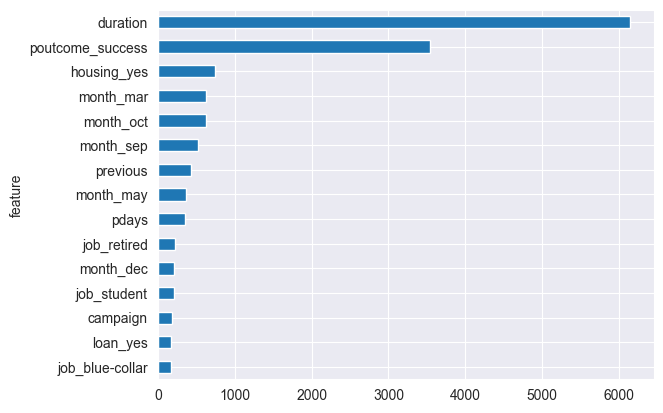

In [54]:
pd.DataFrame({
    'feature': skb.feature_names_in_,
    'score': skb.scores_,
    'pvalue': skb.pvalues_
}).set_index('feature').round(2).sort_values('score').loc[:, 'score'].tail(15).plot.barh()

# X_tr_skb, X_te_skb = X_tr.loc[:, skb.get_feature_names_out()], X_te.loc[:, skb.get_feature_names_out()]

In [55]:
skb.get_feature_names_out()

array(['duration', 'campaign', 'pdays', 'previous', 'job_blue-collar',
       'job_retired', 'job_student', 'housing_yes', 'loan_yes',
       'month_dec', 'month_mar', 'month_may', 'month_oct', 'month_sep',
       'poutcome_success'], dtype=object)

# Import Model Class, Grid Search & Performance Metrics
---

<br>

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
from mdxclf.visualize import plot_confusion_matrix

In [60]:
dict_grid = {
    'max_depth': [5, 10, 12, 15],
    'min_samples_split': [150, 200, 250]
}

gscv = GridSearchCV(
    estimator=DecisionTreeClassifier(class_weight='balanced'), 
    param_grid=dict_grid, 
    scoring='precision', 
    cv=10, 
    n_jobs=-1, 
    verbose=True
)

In [61]:
gscv.fit(X_tr, y_tr)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


,estimator,DecisionTreeC...ht='balanced')
,param_grid,"{'max_depth': [5, 10, ...], 'min_samples_split': [150, 200, ...]}"
,scoring,'precision'
,n_jobs,-1
,refit,True
,cv,10
,verbose,True
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [62]:
pd.DataFrame(gscv.cv_results_).set_index('params').loc[:, 'mean_test_score':].sort_values('rank_test_score')

,mean_test_score,std_test_score,rank_test_score
params,,,
"{'max_depth': 12, 'min_samples_split': 200}",0.382133,0.010185,1
"{'max_depth': 12, 'min_samples_split': 150}",0.381258,0.013155,2
"{'max_depth': 12, 'min_samples_split': 250}",0.380786,0.012137,3
"{'max_depth': 15, 'min_samples_split': 150}",0.378536,0.011036,4
"{'max_depth': 15, 'min_samples_split': 250}",0.376314,0.012625,5
"{'max_depth': 15, 'min_samples_split': 200}",0.375300,0.008321,6
"{'max_depth': 10, 'min_samples_split': 200}",0.365171,0.014646,7
"{'max_depth': 10, 'min_samples_split': 150}",0.363369,0.014747,8
"{'max_depth': 10, 'min_samples_split': 250}",0.362617,0.013057,9


In [63]:
print("Training Performance")
print(classification_report(y_tr, gscv.predict(X_tr)))
print(confusion_matrix(y_tr, gscv.predict(X_tr)))

Training Performance
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     29956
           1       0.40      0.89      0.55      3952

    accuracy                           0.83     33908
   macro avg       0.69      0.86      0.73     33908
weighted avg       0.91      0.83      0.86     33908

[[24760  5196]
 [  449  3503]]


In [64]:
print("Test Performance")
print(classification_report(y_te, gscv.predict(X_te)))
print(confusion_matrix(y_te, gscv.predict(X_te)))

Test Performance
              precision    recall  f1-score   support

           0       0.97      0.82      0.89      9966
           1       0.38      0.83      0.52      1337

    accuracy                           0.82     11303
   macro avg       0.68      0.82      0.71     11303
weighted avg       0.90      0.82      0.85     11303

[[8176 1790]
 [ 228 1109]]


Normalized confusion matrix


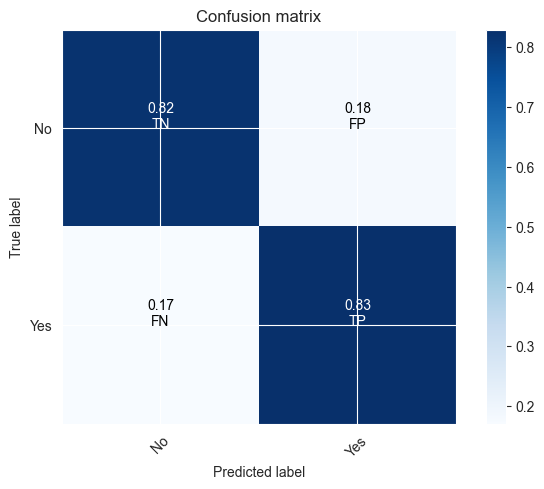

In [121]:
plot_confusion_matrix(cm=confusion_matrix(y_te, gscv.predict(X_te)), 
                      classes=['No', 'Yes'], 
                      normalize=True);

<Axes: ylabel='Frequency'>

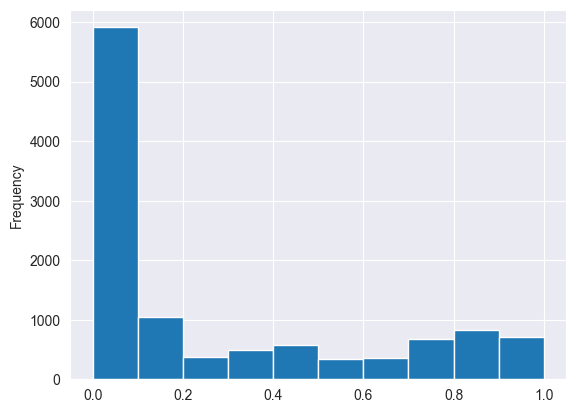

In [141]:
pd.DataFrame(gscv.predict_proba(X_te), columns=['P0', 'P1']).loc[:, 'P1'].plot.hist()

# Trying SVM
---



In [122]:
gscv_svm = GridSearchCV(
    estimator=SVC(), 
    param_grid={
        'C': [4, 6, 8, 12],
        'class_weight': [None, 'balanced'],
        'kernel': ['rbf']
        }, 
    n_jobs=-1, 
    cv=10, 
    scoring='f1_weighted')

X_tr_sampled = X_tr.sample(frac=0.4)
y_tr_sampled = y_tr.loc[X_tr_sampled.index]

gscv_svm.fit(X_tr_sampled, y_tr_sampled)

,estimator,SVC()
,param_grid,"{'C': [4, 6, ...], 'class_weight': [None, 'balanced'], 'kernel': ['rbf']}"
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,4


In [123]:
(pd.DataFrame(gscv_svm.cv_results_)
    .set_index('params')
    .loc[:, 'mean_test_score':]
    .sort_values('rank_test_score'))

,mean_test_score,std_test_score,rank_test_score
params,,,
"{'C': 4, 'class_weight': None, 'kernel': 'rbf'}",0.894605,0.005147,1
"{'C': 6, 'class_weight': None, 'kernel': 'rbf'}",0.893470,0.004695,2
"{'C': 12, 'class_weight': None, 'kernel': 'rbf'}",0.892793,0.006137,3
"{'C': 8, 'class_weight': None, 'kernel': 'rbf'}",0.892637,0.005279,4
"{'C': 12, 'class_weight': 'balanced', 'kernel': 'rbf'}",0.876977,0.009561,5
"{'C': 8, 'class_weight': 'balanced', 'kernel': 'rbf'}",0.876405,0.009177,6
"{'C': 6, 'class_weight': 'balanced', 'kernel': 'rbf'}",0.875487,0.009491,7
"{'C': 4, 'class_weight': 'balanced', 'kernel': 'rbf'}",0.874718,0.008436,8


In [120]:
print(classification_report(y_te, gscv_svm.predict(X_te)))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      9966
           1       0.59      0.39      0.47      1337

    accuracy                           0.90     11303
   macro avg       0.76      0.68      0.71     11303
weighted avg       0.88      0.90      0.89     11303



In [124]:
print(classification_report(y_te, gscv_svm.predict(X_te)))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      9966
           1       0.61      0.37      0.46      1337

    accuracy                           0.90     11303
   macro avg       0.77      0.67      0.70     11303
weighted avg       0.88      0.90      0.89     11303



Normalized confusion matrix


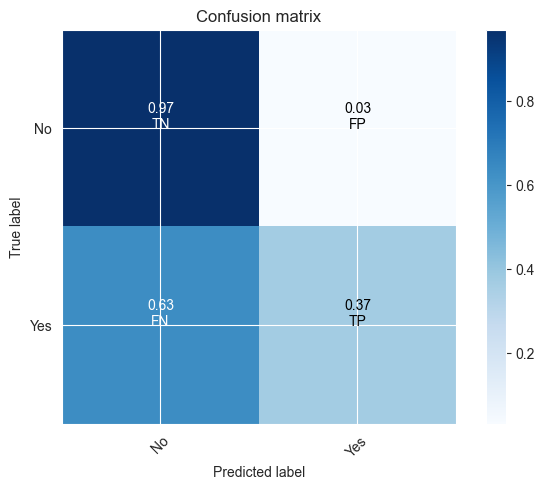

In [125]:
plot_confusion_matrix(cm=confusion_matrix(y_te, gscv_svm.predict(X_te)), 
                      classes=['No', 'Yes'], 
                      normalize=True);

In [120]:
print(classification_report(y_te, gscv_svm.predict(X_te)))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      9966
           1       0.59      0.39      0.47      1337

    accuracy                           0.90     11303
   macro avg       0.76      0.68      0.71     11303
weighted avg       0.88      0.90      0.89     11303



# Trying KNN
---


In [127]:
gscv_knn = GridSearchCV(
    estimator=KNeighborsClassifier(), 
    param_grid={
        'n_neighbors': [6, 8, 10, 12],
        'weights': ['uniform', 'distance'],
        }, 
    n_jobs=-1, 
    cv=10, 
    scoring='f1_weighted')

X_tr_sampled = X_tr.sample(frac=0.5)
y_tr_sampled = y_tr.loc[X_tr_sampled.index]

gscv_knn.fit(X_tr_sampled, y_tr_sampled)

,estimator,KNeighborsClassifier()
,param_grid,"{'n_neighbors': [6, 8, ...], 'weights': ['uniform', 'distance']}"
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,8


In [137]:
print(classification_report(
    y_te,
    (pd.DataFrame(gscv_knn.predict_proba(X_te), columns=['P0', 'P1'])
        .loc[:, 'P1']
        .ge(0.3)
        .astype(int))
))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      9966
           1       0.51      0.50      0.50      1337

    accuracy                           0.88     11303
   macro avg       0.72      0.72      0.72     11303
weighted avg       0.88      0.88      0.88     11303



<Axes: ylabel='Frequency'>

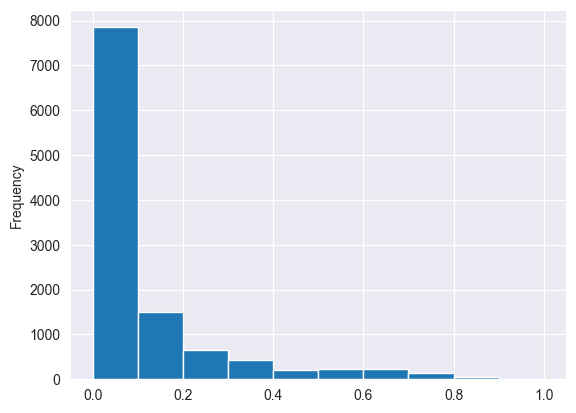

In [139]:
pd.DataFrame(gscv_knn.predict_proba(X_te), columns=['P0', 'P1']).loc[:, 'P1'].plot.hist()

Normalized confusion matrix


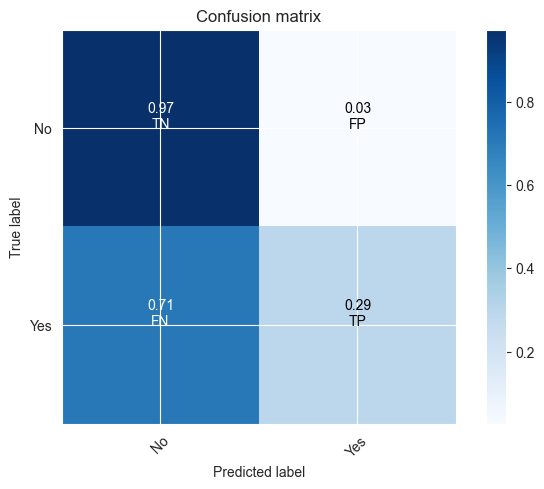

In [129]:
plot_confusion_matrix(cm=confusion_matrix(y_te, gscv_knn.predict(X_te)), 
                      classes=['No', 'Yes'], 
                      normalize=True);

# Voting 
---

In [168]:
df_votes = \
(pd.DataFrame(data={
    'knn': gscv_knn.predict_proba(X_te)[:, 1].round(2),
    'tree': gscv.predict_proba(X_te)[:, 1].round(2),
    'svm': gscv_svm.predict(X_te)
}, index=X_te.index)
    .ge(0.45)
    .astype(int)
    .assign(votes=lambda fr: fr.sum(axis=1))
    .assign(prediction=lambda fr: fr['votes'].ge(2).astype(int))
    .join(y_te.rename('actual'))
)

In [169]:
print(classification_report(
    df_votes['actual'],
    df_votes['prediction']
))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      9966
           1       0.58      0.47      0.52      1337

    accuracy                           0.90     11303
   macro avg       0.76      0.71      0.73     11303
weighted avg       0.89      0.90      0.89     11303



# Activity
---

<big>

- Try a model from the list below
- A grid is suggested, but feel free to change it
- Run GridSearchCV and report the performance

<br>

# The `.predict_proba()` method and the Threshold
---

Normalized confusion matrix


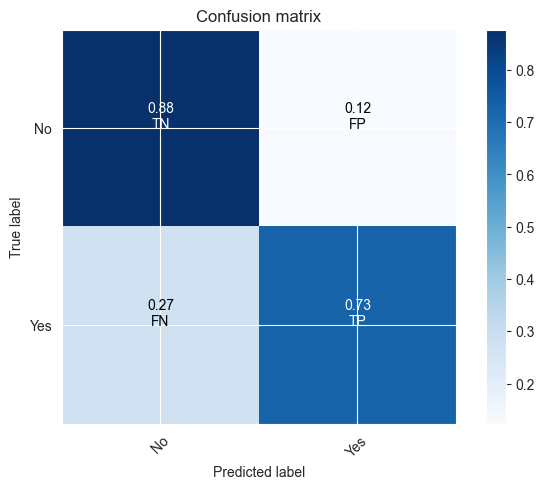

In [86]:
df_proba = (pd.DataFrame(data=gscv.predict_proba(X_te), 
              index=X_te.index,
              columns=['P0', 'P1'])
    .join(y, how='inner')
    .join(pd.Series(gscv.predict(X_te), 
                    name='predicted_y', 
                    index=X_te.index))
 .assign(y_predicted_threshold_60p=lambda fr: fr['P1'].gt(0.7).astype(int))
)

plot_confusion_matrix(cm=confusion_matrix(df_proba['y'], df_proba['y_predicted_threshold_60p']), 
                      classes=["No", 'Yes'], normalize=True)

In [67]:
srs_probabilities = \
(pd.DataFrame(data=gscv.predict_proba(X_te), 
              columns=['P0', 'P1']).loc[:, 'P1'])

In [ ]:
display(srs_probabilities.round(2).head())

ax = srs_probabilities.plot.hist()
ax.vlines(x=0.5, ymin=0, ymax=4500, color='red', linestyle='dashed', linewidth=2)
ax.annotate('default threshold = 0.5', (0.55, 4000));

# Impact of Changing the Threshold
---

<br>

In [87]:
from ipywidgets.widgets import FloatSlider, interact

In [88]:
def f(threshold):
    plot_confusion_matrix(cm=confusion_matrix(y_te, srs_probabilities.gt(threshold).astype(int)), classes=['No', 'Yes'], normalize=True)

interact(
    f,
    threshold=FloatSlider(value=0.5, min=0.3, max=0.8, step=0.05)
)

interactive(children=(FloatSlider(value=0.5, description='threshold', max=0.8, min=0.3, step=0.05), Output()),…

<function __main__.f(threshold)>

# Precision-Recall Curve
---

- helps find the threshold for optimum results

<br>

In [38]:
from sklearn.metrics import precision_recall_curve, roc_curve

In [39]:
p, r, t = precision_recall_curve(y_te, srs_probabilities, pos_label=1)

df_pr = (pd.DataFrame(data=zip(p, r, t),
                      columns=["precision", "recall", "threshold"])
         .set_index("threshold")
         .loc[0.5:0.9]
        )

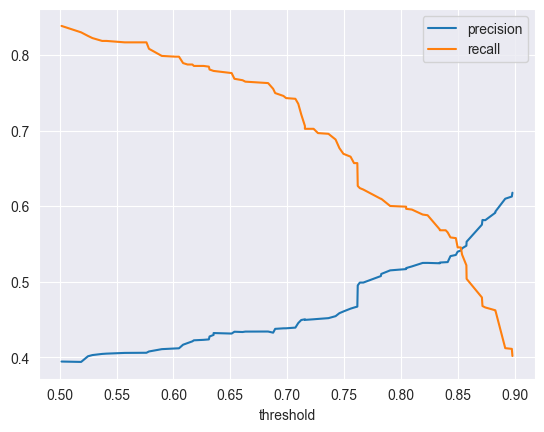

In [40]:
df_pr.plot();

# Ensembles with Pipelines
---

<big>

- Try to build multiple classifiers
- Get them to vote and try to reduce the False Positives

We will use `sklearn.Pipeline` to simplify the process

<br>

In [170]:
from sklearn.pipeline import Pipeline

In [173]:
from sklearn.preprocessing import StandardScaler

In [175]:
pipe_rfo = Pipeline([
    ('scale', StandardScaler()),
    ('skb', SelectKBest()),
    ('model', RandomForestClassifier(max_depth=2))
])

grid_rfo = {
    'skb__k': [10, 15, 20],
    'model__n_estimators': [50, 100, 200],
    'model__min_samples_leaf': [5, 20]
}

In [178]:
pipe_gscv = GridSearchCV(estimator=pipe_rfo, 
                         param_grid=grid_rfo,
                         scoring='f1_weighted',
                         cv=5,
                         n_jobs=-1,
                         verbose=True)

In [179]:
pipe_gscv.fit(X_tr, y_tr)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,estimator,Pipeline(step...ax_depth=2))])
,param_grid,"{'model__min_samples_leaf': [5, 20], 'model__n_estimators': [50, 100, ...], 'skb__k': [10, 15, ...]}"
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [187]:
pd.DataFrame(pipe_gscv.cv_results_).set_index('params').loc[:, 'mean_test_score']

params
{'model__min_samples_leaf': 5, 'model__n_estimators': 50, 'skb__k': 10}      0.834629
{'model__min_samples_leaf': 5, 'model__n_estimators': 50, 'skb__k': 15}      0.828980
{'model__min_samples_leaf': 5, 'model__n_estimators': 50, 'skb__k': 20}      0.828852
{'model__min_samples_leaf': 5, 'model__n_estimators': 100, 'skb__k': 10}     0.834400
{'model__min_samples_leaf': 5, 'model__n_estimators': 100, 'skb__k': 15}     0.828780
{'model__min_samples_leaf': 5, 'model__n_estimators': 100, 'skb__k': 20}     0.828780
{'model__min_samples_leaf': 5, 'model__n_estimators': 200, 'skb__k': 10}     0.833911
{'model__min_samples_leaf': 5, 'model__n_estimators': 200, 'skb__k': 15}     0.828852
{'model__min_samples_leaf': 5, 'model__n_estimators': 200, 'skb__k': 20}     0.828780
{'model__min_samples_leaf': 20, 'model__n_estimators': 50, 'skb__k': 10}     0.834512
{'model__min_samples_leaf': 20, 'model__n_estimators': 50, 'skb__k': 15}     0.828852
{'model__min_samples_leaf': 20, 'model__n_estim

In [197]:
print(classification_report(y_te, 
                            [1 if x > 0.27 else 0 for x in pipe_gscv.predict_proba(X_te)[:, 1]]
                            ))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      9966
           1       0.64      0.20      0.31      1337

    accuracy                           0.89     11303
   macro avg       0.77      0.59      0.62     11303
weighted avg       0.87      0.89      0.87     11303

